# **Configuración de entorno**

In [ ]:
root = '/content/temp_drive'

In [ ]:
from google.colab import drive
drive.mount(root)

Drive already mounted at /content/temp_drive; to attempt to forcibly remount, call drive.mount("/content/temp_drive", force_remount=True).


In [ ]:
%cd "{root}/MyDrive/monografia/Codigo"

/content/temp_drive/MyDrive/monografia/Codigo


# **Cargue de Librerías**

In [ ]:
%run 00_configuracion_entorno.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Carga de archivo fuentes**

Se realiza el proceso de carga de los archivos correspondiente a cada moneda de análisis

In [ ]:
%cd "{root}/MyDrive/monografia/Salidas"

/content/temp_drive/MyDrive/monografia/Salidas


In [ ]:
df_Coins_Close = pd.read_csv("dataframe_bitcoin_preprocesado.csv", sep=';')

In [ ]:
df_Coins_Close.shape

(2991, 2)

# **Selección de campos y creación de conjuntos**

In [ ]:
df_Coins_Close.head(100)

,Date,Close
0,2013-04-29,2.159988
1,2013-04-30,2.143015
2,2013-05-01,2.068149
3,2013-05-02,2.022057
4,2013-05-03,1.990117
...,...,...
95,2013-08-02,2.019120
96,2013-08-03,2.017054
97,2013-08-04,2.021784
98,2013-08-05,2.026206


In [ ]:
bitcoinClose = df_Coins_Close[["Close","Date"]]
bitcoinClose.set_index("Date", inplace=True)

In [ ]:
Close_data = bitcoinClose.values
Close_data = Close_data.reshape((-1,1))

split_percent_tra = 0.70
split_percent_val = 0.80

split = int(split_percent_tra*len(Close_data))
split_val = int(split_percent_val*len(Close_data))

Close_train = Close_data[:split]
Close_validation = Close_data[split:split_val]
Close_test = Close_data[split_val:]

date_train = bitcoinClose.index[:split]
date_validation = bitcoinClose.index[split:split_val]
date_test = bitcoinClose.index[split_val:]

print(len(Close_train))
print(len(Close_validation))
print(len(Close_test))


print(len(date_train))
print(len(date_validation))
print(len(date_test))

2093
299
599
2093
299
599


# **Normalización de los datos**

Se aplica el valor de look_back hallado previamente en el análisis exploratorio a los datos de entrenamiento y testing

Se crea el modelo de la red Neuronal y se entrena el modelo con 10 épocas que es el número de épocas que se evidenció de manera experimental que funcionaría para este caso

In [ ]:
scaler = MinMaxScaler()
scaler.fit(Close_train)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(Close_train)
scaled_test = scaler.transform(Close_test)
scaled_validation = scaler.transform(Close_validation)

In [ ]:
look_back = 7

trainX, trainY = create_dataset(scaled_train, look_back)
ValX, ValY = create_dataset(scaled_validation, look_back)
testX, testY = create_dataset(scaled_test, look_back)

In [ ]:
trainX.shape

(2085, 7)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0],look_back,1))
testX = np.reshape(testX, (testX.shape[0],look_back,1))
ValX = np.reshape(ValX, (ValX.shape[0],look_back,1))

In [ ]:
trainY.shape, testY.shape, ValY.shape

((2085,), (591,), (291,))

In [ ]:
trainX.shape, testX.shape, ValX.shape

((2085, 7, 1), (591, 7, 1), (291, 7, 1))

# **Revese TrainY, testY, ValY**

In [ ]:
trainY_inv = trainY.reshape((-1))
trainY_inv = scaler.inverse_transform(trainY_inv.reshape(-1, 1))

ValY_inv = ValY.reshape((-1))
ValY_inv = scaler.inverse_transform(ValY_inv.reshape(-1, 1))

testY_inv = testY.reshape((-1))
testY_inv = scaler.inverse_transform(testY_inv.reshape(-1, 1))

In [ ]:
trainY_inv.shape, testY_inv.shape, ValY_inv.shape

((2085, 1), (591, 1), (291, 1))

In [ ]:
trainY_usd, ValY_usd, testY_usd  = inversa_logaritmo(trainY_inv, 
                                                    ValY_inv, 
                                                    testY_inv)

In [ ]:
Close_train_usd, Close_validation_usd, Close_test_usd = inversa_logaritmo(Close_train, 
                                                                          Close_validation, 
                                                                          Close_test)

# **Modelo Convolucional**

In [ ]:
modelCONV = Sequential()
modelCONV.add(Conv1D(64, 
                     kernel_size=3, 
                     input_shape=(look_back,1)))
modelCONV.add(Dropout(0.2))
modelCONV.add(Conv1D(64, 
                     kernel_size=3, 
                     input_shape=(look_back,1)))
modelCONV.add(Dropout(0.2))
modelCONV.add(Conv1D(64, 
                     kernel_size=3, 
                     input_shape=(look_back,1)))
modelCONV.add(Dropout(0.2))
modelCONV.add(Flatten())
modelCONV.add(Dense(units=1))

modelCONV.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                  loss='mean_squared_error',
                   metrics = ['mae','mape'])

## **Entrenamiento del modelo**

In [ ]:
num_epochs = 40
historyCONV = modelCONV.fit(trainX,
                            trainY, 
                            epochs=num_epochs, 
                            batch_size=1, 
                            verbose=2, 
                            validation_data = (ValX, ValY))

Epoch 1/40
2085/2085 - 4s - loss: 0.0059 - mae: 0.0487 - mape: 49325.9727 - val_loss: 0.0016 - val_mae: 0.0388 - val_mape: 4.6963 - 4s/epoch - 2ms/step
Epoch 2/40
2085/2085 - 3s - loss: 0.0016 - mae: 0.0302 - mape: 44319.5156 - val_loss: 0.0020 - val_mae: 0.0427 - val_mape: 5.1582 - 3s/epoch - 1ms/step
Epoch 3/40
2085/2085 - 3s - loss: 0.0015 - mae: 0.0293 - mape: 34200.0234 - val_loss: 7.5654e-04 - val_mae: 0.0254 - val_mape: 3.1179 - 3s/epoch - 1ms/step
Epoch 4/40
2085/2085 - 3s - loss: 0.0014 - mae: 0.0282 - mape: 16450.5508 - val_loss: 3.2232e-04 - val_mae: 0.0151 - val_mape: 1.8167 - 3s/epoch - 1ms/step
Epoch 5/40
2085/2085 - 3s - loss: 0.0013 - mae: 0.0266 - mape: 30220.0195 - val_loss: 3.0181e-04 - val_mae: 0.0147 - val_mape: 1.7806 - 3s/epoch - 1ms/step
Epoch 6/40
2085/2085 - 3s - loss: 0.0011 - mae: 0.0249 - mape: 44079.3906 - val_loss: 0.0012 - val_mae: 0.0331 - val_mape: 4.0032 - 3s/epoch - 1ms/step
Epoch 7/40
2085/2085 - 3s - loss: 0.0013 - mae: 0.0270 - mape: 18058.5664 - 

## **Resumen del modelo**

In [ ]:
modelCONV.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 64)             256       
                                                                 
 dropout_10 (Dropout)        (None, 5, 64)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 3, 64)             12352     
                                                                 
 dropout_11 (Dropout)        (None, 3, 64)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             12352     
                                                                 
 dropout_12 (Dropout)        (None, 1, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 64)               

## **Visualización error**

In [ ]:
df_historyCONV = pd.DataFrame(historyCONV.history)
df_historyCONV

,loss,mae,mape,val_loss,val_mae,val_mape
0,0.005888,0.048679,49325.972656,0.001631,0.038766,4.696260
1,0.001640,0.030185,44319.515625,0.001970,0.042735,5.158162
2,0.001495,0.029277,34200.023438,0.000757,0.025392,3.117934
3,0.001407,0.028234,16450.550781,0.000322,0.015098,1.816710
4,0.001290,0.026610,30220.019531,0.000302,0.014662,1.780607
5,0.001097,0.024876,44079.390625,0.001217,0.033115,4.003181
6,0.001320,0.027019,18058.566406,0.002181,0.045376,5.496686
7,0.001197,0.025848,34838.210938,0.000325,0.015187,1.818513
8,0.001061,0.024234,6350.098145,0.000304,0.015447,1.902656
9,0.001195,0.025968,19417.951172,0.000131,0.009249,1.119489


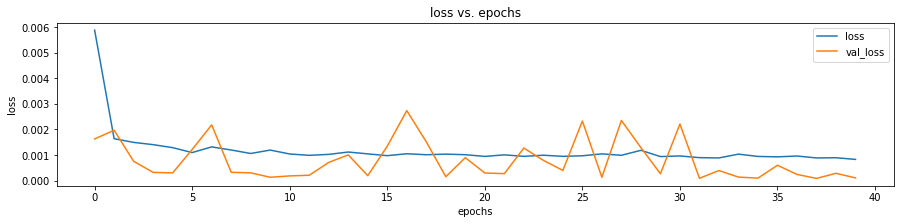

In [ ]:
df_historyCONV.plot(y=['loss', 'val_loss'], 
                title='loss vs. epochs', 
                xlabel='epochs', 
                ylabel='loss', legend=True,figsize=(15,3))

plt.savefig("loss_val_loss_Conv.jpg", bbox_inches='tight')

plt.show()

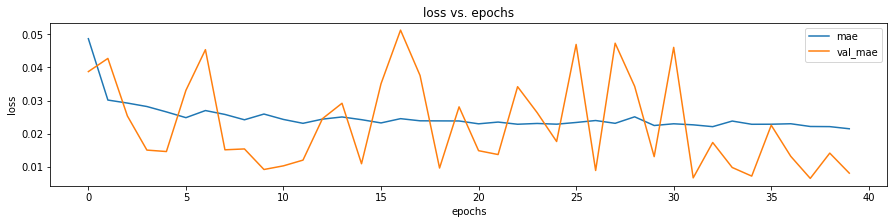

In [ ]:
df_historyCONV.plot(y=['mae', 'val_mae'], 
                title='loss vs. epochs', 
                xlabel='epochs', 
                ylabel='loss', legend=True, figsize=(15,3))

plt.savefig("mae_vs_val_mae_Conv.jpg", bbox_inches='tight')

plt.show()

## **Predict**

In [ ]:
trainPredict_CONV = modelCONV.predict(trainX)
testPredict_CONV = modelCONV.predict(testX)

In [ ]:
ValidationPredict_CONV = modelCONV.predict(ValX)

In [ ]:
trainPredict_CONV.shape,trainX.shape

((2085, 1), (2085, 7, 1))

## **Error de Entrenamiento**


In [ ]:
Train_mseconv = mean_squared_error(trainY, trainPredict_CONV) 
Train_maeconv = mean_absolute_error(trainY, trainPredict_CONV)
Train_mapeconv = mean_absolute_percentage_error(trainY, trainPredict_CONV)
print('Train Score: %.2f MSE' % (Train_mseconv))
print('Train Score: %.2f MAE' % (Train_maeconv))

Train Score: 0.00 MSE
Train Score: 0.01 MAE


## **Error de Test**

In [ ]:
Test_mseconv = mean_squared_error(testY, testPredict_CONV) 
Test_maeconv = mean_absolute_error(testY, testPredict_CONV)
Test_mapeconv = mean_absolute_percentage_error(testY, testPredict_CONV)
print('Test Score: %.2f MSE' % (Test_mseconv))
print('Test Score: %.2f MAE' % (Test_maeconv))

Test Score: 0.00 MSE
Test Score: 0.01 MAE


## **Reverse**

In [ ]:
testPredict_CONV = testPredict_CONV.reshape((-1))
trainPredict_CONV = trainPredict_CONV.reshape((-1))
ValidationPredict_CONV = ValidationPredict_CONV.reshape((-1,1))

In [ ]:
trainPredict_CONV = scaler.inverse_transform(trainPredict_CONV.reshape(-1, 1))
testPredict_CONV = scaler.inverse_transform(testPredict_CONV.reshape(-1, 1))
ValidationPredict_CONV = scaler.inverse_transform(ValidationPredict_CONV.reshape(-1,1))

## **Grafica escala logaritmica CONV1D**

In [ ]:
trainPredict_CONV_usd, ValidationPredict_CONV_usd, testPredict_CONV_usd = inversa_logaritmo(trainPredict_CONV, 
                                                                                            ValidationPredict_CONV, 
                                                                                            testPredict_CONV)

In [ ]:
data_predict = np.concatenate([trainPredict_CONV,ValidationPredict_CONV, testPredict_CONV])
data = np.concatenate([trainY_inv,ValY_inv, testY_inv])

c = np.concatenate((data_predict.reshape(-1,1), data.reshape(-1,1)),axis=1)
df_error = pd.DataFrame(c, columns=['data_predict','data'])

df_error['Test_mregru'] =  df_error.apply(lambda x: mrea(x.data_predict, x.data), axis = 1)

mregru_conv = np.array(df_error.Test_mregru)

del df_error
mregru_conv_av = round(np.average(mregru_conv),2)

In [ ]:
mregru_conv_av

0.01

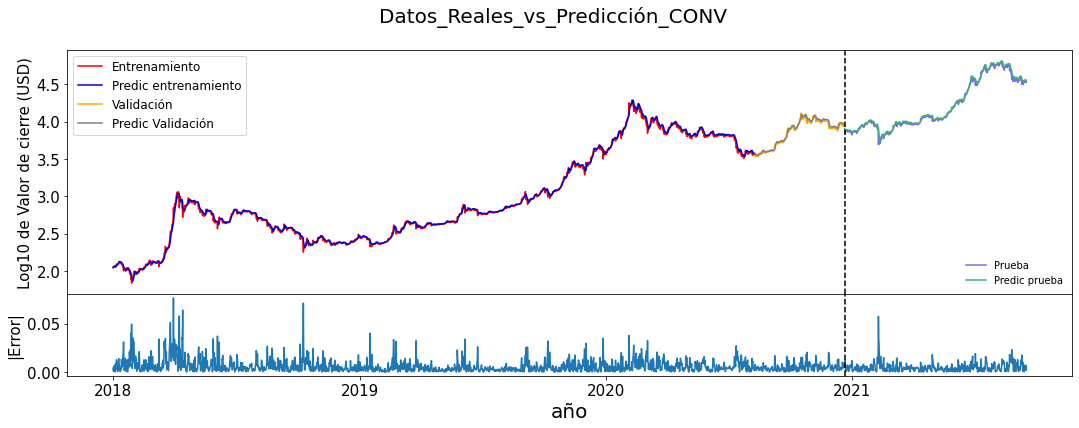

In [ ]:
graficar_prediccion(date_train[8:], 
                    trainY_inv,
                    date_validation[8:], 
                    ValY_inv,
                    date_test[8:], 
                    testY_inv,
                    trainPredict_CONV,
                    testPredict_CONV,
                    ValidationPredict_CONV,
                    mregru_conv,"Datos_Reales_vs_Predicción_CONV")

# **Modelo SimpleRNN**

## **Arquitectura de la red**

In [ ]:
modelRNN = keras.models.Sequential([keras.layers.SimpleRNN(units=20, return_sequences=True, input_shape=(look_back,1)),
                                 keras.layers.SimpleRNN(units=20),
                                 keras.layers.Dropout(0.4),
                                 keras.layers.Dense(units=1)
])

## **Compilar modelo**

In [ ]:
modelRNN.compile(optimizer= tf.keras.optimizers.Adam(),
              loss = keras.losses.mse,
              metrics=['mae', 'mape'])

## **Entrenamiento del modelo**

In [ ]:
num_epochs = 15
historyRNN = modelRNN.fit(trainX,
                          trainY, 
                          epochs=num_epochs, 
                          batch_size=1, 
                          verbose=2, 
                          validation_data = (ValX, ValY))

Epoch 1/15
2085/2085 - 9s - loss: 0.0205 - mae: 0.0985 - mape: 32018.6836 - val_loss: 6.8304e-04 - val_mae: 0.0219 - val_mape: 2.5631 - 9s/epoch - 4ms/step
Epoch 2/15
2085/2085 - 8s - loss: 0.0066 - mae: 0.0546 - mape: 179.6486 - val_loss: 0.0028 - val_mae: 0.0519 - val_mape: 6.4112 - 8s/epoch - 4ms/step
Epoch 3/15
2085/2085 - 8s - loss: 0.0038 - mae: 0.0418 - mape: 6493.2686 - val_loss: 1.5285e-04 - val_mae: 0.0101 - val_mape: 1.2741 - 8s/epoch - 4ms/step
Epoch 4/15
2085/2085 - 9s - loss: 0.0032 - mae: 0.0393 - mape: 113375.6562 - val_loss: 1.0176e-04 - val_mae: 0.0079 - val_mape: 0.9577 - 9s/epoch - 4ms/step
Epoch 5/15
2085/2085 - 7s - loss: 0.0029 - mae: 0.0381 - mape: 11110.8721 - val_loss: 0.0018 - val_mae: 0.0402 - val_mape: 4.7837 - 7s/epoch - 3ms/step
Epoch 6/15
2085/2085 - 8s - loss: 0.0028 - mae: 0.0375 - mape: 51710.1328 - val_loss: 2.2597e-04 - val_mae: 0.0136 - val_mape: 1.6957 - 8s/epoch - 4ms/step
Epoch 7/15
2085/2085 - 8s - loss: 0.0026 - mae: 0.0369 - mape: 25152.6504 

## **Visualización error**

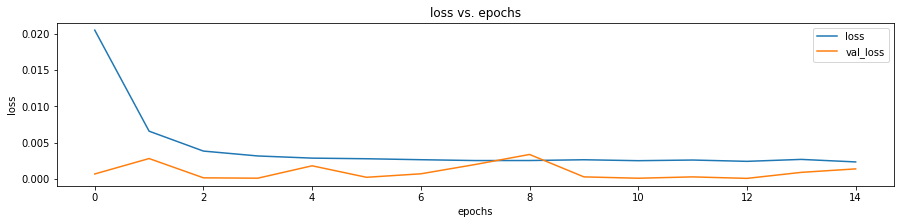

In [ ]:
df_historyRNN = pd.DataFrame(historyRNN.history)

df_historyRNN.plot(y=['loss', 'val_loss'], 
                title='loss vs. epochs', 
                xlabel='epochs', 
                ylabel='loss', legend=True, figsize=(15,3))
plt.savefig("loss_vs_epochs_RNN.jpg", bbox_inches='tight')

plt.show()

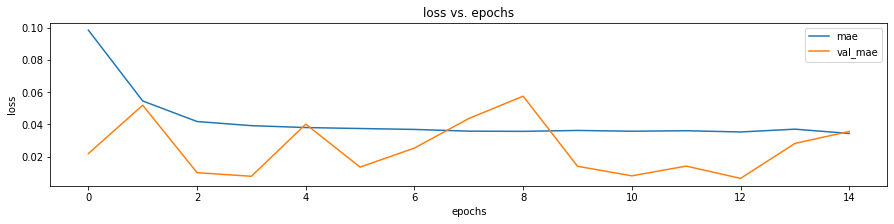

In [ ]:
df_historyRNN.plot(y=['mae', 'val_mae'], 
                title='loss vs. epochs', 
                xlabel='epochs', 
                ylabel='loss', legend=True, figsize=(15,3))

plt.savefig("mae_vs_val_mae_RNN.jpg", bbox_inches='tight')

plt.show()

## **Predict**

In [ ]:
trainPredict_RNN = modelRNN.predict(trainX)
testPredict_RNN = modelRNN.predict(testX)

In [ ]:
ValidationPredict_RNN = modelRNN.predict(ValX)

In [ ]:
trainPredict_RNN.shape, trainX.shape

((2085, 1), (2085, 7, 1))

## **Error de Entrenamiento** 

In [ ]:
Train_msernn = mean_squared_error(trainY, trainPredict_RNN) 
Train_maernn = mean_absolute_error(trainY, trainPredict_RNN)
Train_mapernn = mean_absolute_percentage_error(trainY, trainPredict_RNN)
print('Train Score: %.2f MSE' % (Train_msernn))
print('Train Score: %.2f MAE' % (Train_maernn))

Train Score: 0.00 MSE
Train Score: 0.02 MAE


## **Error de Test**

In [ ]:
Test_msernn = mean_squared_error(testY, testPredict_RNN) 
Test_maernn = mean_absolute_error(testY, testPredict_RNN)
Test_mapernn = mean_absolute_percentage_error(testY, testPredict_RNN)
print('Test Score: %.2f MSE' % (Test_msernn))
print('Test Score: %.2f MAE' % (Test_maernn))

Test Score: 0.00 MSE
Test Score: 0.06 MAE


## **Reverse**

In [ ]:
testPredict_RNN = testPredict_RNN.reshape((-1))
trainPredict_RNN = trainPredict_RNN.reshape((-1))

In [ ]:
ValidationPredict_RNN = ValidationPredict_RNN.reshape(-1)

In [ ]:
trainPredict_RNN = scaler.inverse_transform(trainPredict_RNN.reshape(-1, 1))
testPredict_RNN = scaler.inverse_transform(testPredict_RNN.reshape(-1, 1))

In [ ]:
ValidationPredict_RNN = scaler.inverse_transform(ValidationPredict_RNN.reshape(-1,1))

## **Grafica simpleRNN**

In [ ]:
trainPredict_RNN_usd, ValidationPredict_RNN_usd, testPredict_RNN_usd = inversa_logaritmo(trainPredict_RNN, 
                                                                                            ValidationPredict_RNN, 
                                                                                            testPredict_RNN)

In [ ]:
data_predict = np.concatenate([trainPredict_RNN,ValidationPredict_RNN, testPredict_RNN])
data = np.concatenate([trainY_inv,ValY_inv, testY_inv])

c = np.concatenate((data_predict.reshape(-1,1), data.reshape(-1,1)),axis=1)
df_error = pd.DataFrame(c, columns=['data_predict','data'])

df_error['Test_mregru'] =  df_error.apply(lambda x: mrea(x.data_predict, x.data), axis = 1)

mregru_rnn = np.array(df_error.Test_mregru)

del df_error
mregru_rnn_av = round(np.average(mregru_rnn),2)

In [ ]:
mregru_rnn_av

0.02

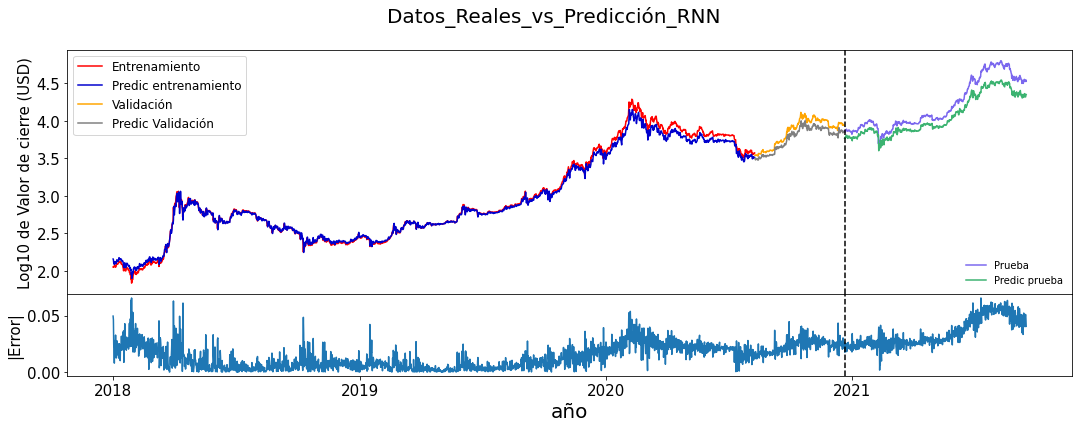

In [ ]:
graficar_prediccion(date_train[8:], 
                    trainY_inv,
                    date_validation[8:], 
                    ValY_inv,
                    date_test[8:], 
                    testY_inv,
                    trainPredict_RNN,
                    testPredict_RNN,
                    ValidationPredict_RNN,
                    mregru_rnn,"Datos_Reales_vs_Predicción_RNN")

# **Modelo LSTM**

## **Arquitectura de la red**

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units=64, kernel_initializer = 'glorot_uniform',activation='tanh', return_sequences=True, input_shape=(trainX.shape[1],1)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(units=64))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units=1))

## **Compilar modelo**

In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)

modelLSTM.compile(optimizer=optimizer,
                   loss='mae', 
                   metrics = ['mse'] )

## **Entrenamiento del modelo**

In [ ]:
num_epochs = 40
historyLSTM = modelLSTM.fit(trainX,
                            trainY, 
                            epochs=num_epochs, 
                            batch_size=1, 
                            verbose=2, 
                            validation_data = (ValX, ValY))

Epoch 1/40
2085/2085 - 20s - loss: 0.0533 - mse: 0.0056 - val_loss: 0.1320 - val_mse: 0.0184 - 20s/epoch - 10ms/step
Epoch 2/40
2085/2085 - 15s - loss: 0.0397 - mse: 0.0030 - val_loss: 0.0308 - val_mse: 0.0011 - 15s/epoch - 7ms/step
Epoch 3/40
2085/2085 - 16s - loss: 0.0368 - mse: 0.0025 - val_loss: 0.0138 - val_mse: 2.7624e-04 - 16s/epoch - 8ms/step
Epoch 4/40
2085/2085 - 16s - loss: 0.0315 - mse: 0.0018 - val_loss: 0.0786 - val_mse: 0.0066 - 16s/epoch - 8ms/step
Epoch 5/40
2085/2085 - 15s - loss: 0.0329 - mse: 0.0020 - val_loss: 0.0932 - val_mse: 0.0091 - 15s/epoch - 7ms/step
Epoch 6/40
2085/2085 - 14s - loss: 0.0304 - mse: 0.0017 - val_loss: 0.0165 - val_mse: 4.2767e-04 - 14s/epoch - 7ms/step
Epoch 7/40
2085/2085 - 14s - loss: 0.0280 - mse: 0.0015 - val_loss: 0.0111 - val_mse: 1.7869e-04 - 14s/epoch - 7ms/step
Epoch 8/40
2085/2085 - 15s - loss: 0.0287 - mse: 0.0016 - val_loss: 0.0940 - val_mse: 0.0092 - 15s/epoch - 7ms/step
Epoch 9/40
2085/2085 - 16s - loss: 0.0281 - mse: 0.0015 - v

## **Resumen del modelo**

In [ ]:
modelLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 dropout_14 (Dropout)        (None, 7, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


## **Visualización error**

In [ ]:
df_historyLSTM = pd.DataFrame(historyLSTM.history)
df_historyLSTM

,loss,mse,val_loss,val_mse
0,0.053309,0.005597,0.132025,0.018359
1,0.039713,0.003028,0.030778,0.001135
2,0.036771,0.002538,0.013822,0.000276
3,0.031526,0.001833,0.078645,0.006615
4,0.032860,0.001997,0.093180,0.009099
5,0.030403,0.001686,0.016493,0.000428
6,0.028006,0.001471,0.011074,0.000179
7,0.028668,0.001565,0.094034,0.009193
8,0.028052,0.001481,0.009993,0.000171
9,0.026731,0.001346,0.025954,0.000772


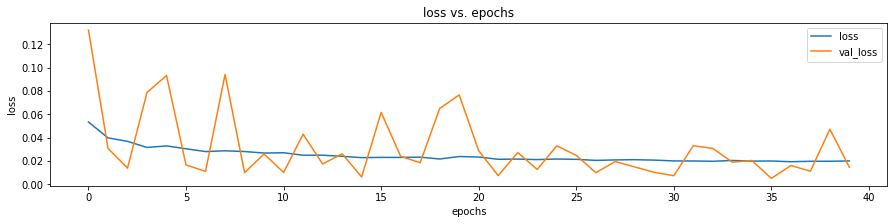

In [ ]:
df_historyLSTM = pd.DataFrame(historyLSTM.history)
df_historyLSTM.plot(y=['loss', 'val_loss'], 
                title='loss vs. epochs', 
                xlabel='epochs', 
                ylabel='loss', legend=True, figsize=(15,3))

plt.savefig("loss_vs_epochs.jpg", bbox_inches='tight')

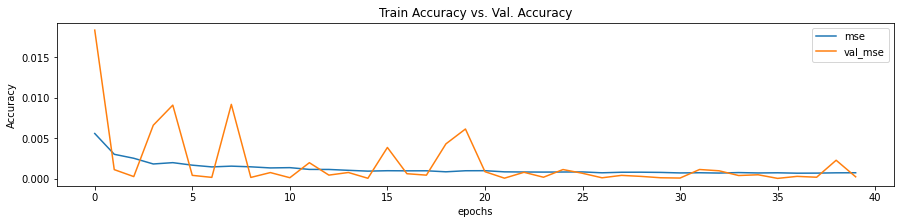

In [ ]:
df_historyLSTM.plot(y=['mse', 'val_mse'],
                title='Train Accuracy vs. Val. Accuracy',
                xlabel='epochs',
                ylabel='Accuracy',
                legend=True,
                figsize=(15,3)
                )
plt.savefig("Train_Accuracy_Val_Accuracy LSTM.jpg", bbox_inches='tight')

## **Predict**

In [ ]:
trainPredictLSTM = modelLSTM.predict(trainX)
testPredictLSTM = modelLSTM.predict(testX)

In [ ]:
ValidationPredictLSTM = modelLSTM.predict(ValX)

In [ ]:
trainPredictLSTM.shape, trainX.shape,ValX.shape

((2085, 1), (2085, 7, 1), (291, 7, 1))

In [ ]:
testPredictLSTM.shape

(591, 1)

## **Error de Entrenamiento**

In [ ]:
Train_mselstm = mean_squared_error(trainY, trainPredictLSTM) 
Train_maelstm = mean_absolute_error(trainY, trainPredictLSTM)
Train_mapelstm = mean_absolute_percentage_error(trainY, trainPredictLSTM)
print('Train Score: %.2f MSE' % (Train_mselstm))
print('Train Score: %.2f MAE' % (Train_maelstm))

Train Score: 0.00 MSE
Train Score: 0.01 MAE


## **Error de Test**

In [ ]:
Test_mselstm = mean_squared_error(testY, testPredictLSTM) 
Test_maelstm = mean_absolute_error(testY, testPredictLSTM)
Test_mapelstm = mean_absolute_percentage_error(testY, testPredictLSTM)
print('Test Score: %.2f MSE' % (Test_mselstm))
print('Test Score: %.2f MAE' % (Test_maelstm))

Test Score: 0.00 MSE
Test Score: 0.02 MAE


## **Revese**

In [ ]:
testPredictLSTM = testPredictLSTM.reshape((-1))
trainPredictLSTM = trainPredictLSTM.reshape((-1))

In [ ]:
ValidationPredictLSTM = ValidationPredictLSTM.reshape((-1))

In [ ]:
testPredictLSTM.shape

(591,)

In [ ]:
trainPredictLSTM.shape

(2085,)

In [ ]:
#predictions = scaler.inverse_transform(prediction_scaled)
trainPredictLSTM = scaler.inverse_transform(trainPredictLSTM.reshape(-1, 1))
testPredictLSTM = scaler.inverse_transform(testPredictLSTM.reshape(-1, 1))
ValidationPredictLSTM = scaler.inverse_transform(ValidationPredictLSTM.reshape(-1,1))

## **Grafica valor real LSTM**

In [ ]:
trainPredict_LSTM_usd, ValidationPredict_LSTM_usd, testPredict_LSTM_usd = inversa_logaritmo(trainPredictLSTM, 
                                                                                            ValidationPredictLSTM, 
                                                                                            testPredictLSTM)

In [ ]:
data_predict = np.concatenate([trainPredictLSTM,ValidationPredictLSTM, testPredictLSTM])
data = np.concatenate([trainY_inv,ValY_inv, testY_inv])

c = np.concatenate((data_predict.reshape(-1,1), data.reshape(-1,1)),axis=1)
df_error = pd.DataFrame(c, columns=['data_predict','data'])

df_error['Test_mregru'] =  df_error.apply(lambda x: mrea(x.data_predict, x.data), axis = 1)

mregru_lstm = np.array(df_error.Test_mregru)

del df_error
mregru_lstm_av = round(np.average(mregru_lstm),2)

In [ ]:
mregru_lstm_av

0.01

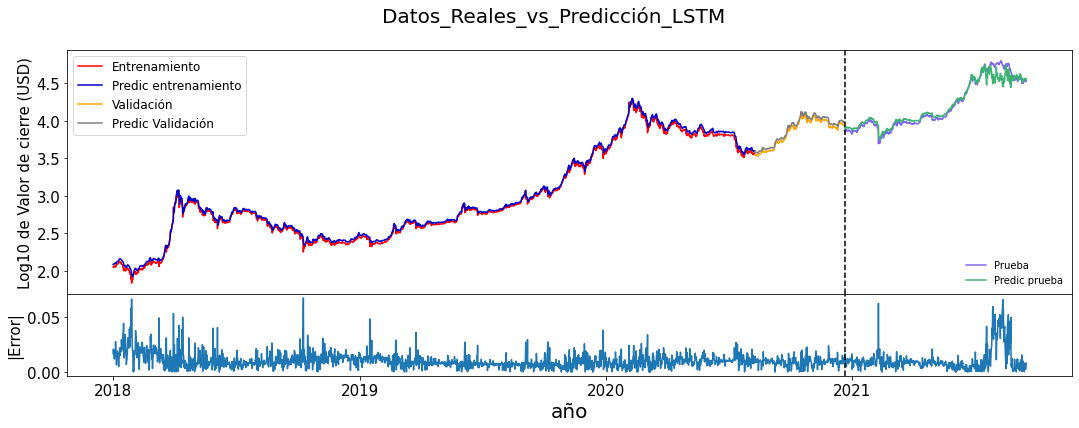

In [ ]:
graficar_prediccion(date_train[8:], 
                    trainY_inv,
                    date_validation[8:], 
                    ValY_inv,
                    date_test[8:], 
                    testY_inv,
                    trainPredictLSTM,
                    testPredictLSTM,
                    ValidationPredictLSTM,
                    mregru_lstm,"Datos_Reales_vs_Predicción_LSTM")

# **Modelo GRU**

## **Arquitectura de la red**

In [ ]:
ModelGRU = Sequential()
ModelGRU.add(GRU(units=64, return_sequences=True, input_shape=(look_back,1), kernel_initializer = 'he_uniform',activation='tanh'))
ModelGRU.add(Dropout(0.2))
ModelGRU.add(GRU(units=100, return_sequences=True, input_shape=(look_back,1), kernel_initializer = 'he_uniform', activation='tanh'))
ModelGRU.add(Dropout(0.2))
ModelGRU.add(GRU(units=128, return_sequences=True, input_shape=(look_back,1), kernel_initializer = 'he_uniform', activation='tanh'))
ModelGRU.add(Dropout(0.2))
ModelGRU.add(GRU(units=256, activation='tanh'))
ModelGRU.add(Dropout(0.2))
ModelGRU.add(Dense(units=1))

## **Compilar modelo**

In [ ]:
ModelGRU.compile(optimizer=SGD(learning_rate=0.01, 
                               decay=1e-7, 
                               momentum=0.8, 
                               nesterov=False),
                               loss='mean_squared_error',
                              metrics=['mae', 'mape'])

## **Resumen del modelo**

In [ ]:
ModelGRU.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 7, 64)             12864     
                                                                 
 dropout_16 (Dropout)        (None, 7, 64)             0         
                                                                 
 gru_5 (GRU)                 (None, 7, 100)            49800     
                                                                 
 dropout_17 (Dropout)        (None, 7, 100)            0         
                                                                 
 gru_6 (GRU)                 (None, 7, 128)            88320     
                                                                 
 dropout_18 (Dropout)        (None, 7, 128)            0         
                                                                 
 gru_7 (GRU)                 (None, 256)              

## **Entrenamiento del modelo**

In [ ]:
num_epochs = 40
historyGRU = ModelGRU.fit(trainX,
                          trainY, 
                          epochs=num_epochs, 
                          batch_size=1, 
                          verbose=2, 
                          validation_data = (ValX, ValY))

Epoch 1/40
2085/2085 - 43s - loss: 0.0185 - mae: 0.0763 - mape: 30662.2910 - val_loss: 0.0044 - val_mae: 0.0651 - val_mape: 8.0480 - 43s/epoch - 21ms/step
Epoch 2/40
2085/2085 - 35s - loss: 0.0028 - mae: 0.0407 - mape: 41261.5039 - val_loss: 0.0216 - val_mae: 0.1464 - val_mape: 17.8601 - 35s/epoch - 17ms/step
Epoch 3/40
2085/2085 - 33s - loss: 0.0023 - mae: 0.0365 - mape: 29189.9551 - val_loss: 0.0093 - val_mae: 0.0960 - val_mape: 11.7570 - 33s/epoch - 16ms/step
Epoch 4/40
2085/2085 - 38s - loss: 0.0020 - mae: 0.0344 - mape: 27110.0859 - val_loss: 0.0121 - val_mae: 0.1088 - val_mape: 13.2014 - 38s/epoch - 18ms/step
Epoch 5/40
2085/2085 - 38s - loss: 0.0018 - mae: 0.0329 - mape: 2399.2073 - val_loss: 0.0088 - val_mae: 0.0930 - val_mape: 11.3884 - 38s/epoch - 18ms/step
Epoch 6/40
2085/2085 - 39s - loss: 0.0016 - mae: 0.0307 - mape: 78688.9375 - val_loss: 4.6569e-04 - val_mae: 0.0194 - val_mape: 2.4247 - 39s/epoch - 19ms/step
Epoch 7/40
2085/2085 - 41s - loss: 0.0016 - mae: 0.0307 - mape:

## **Visualización error**

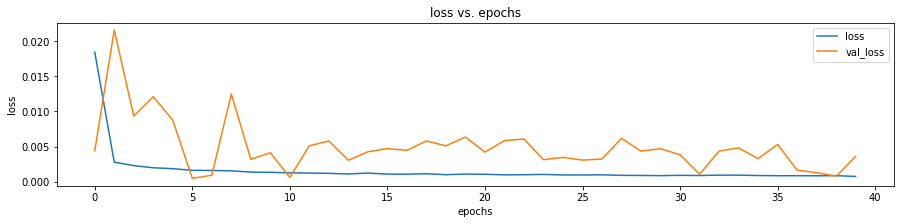

In [ ]:
df_historyGRU = pd.DataFrame(historyGRU.history)

df_historyGRU.plot(y=['loss', 'val_loss'], 
                title='loss vs. epochs', 
                xlabel='epochs', 
                ylabel='loss', legend=True, figsize=(15,3))
plt.savefig("loss_vs_epochs_GRU.jpg", bbox_inches='tight')
plt.show()

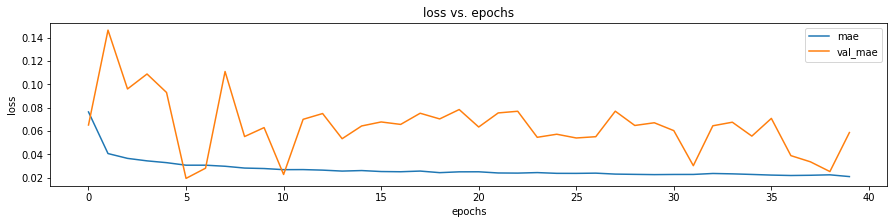

In [ ]:
df_historyGRU.plot(y=['mae', 'val_mae'], 
                title='loss vs. epochs', 
                xlabel='epochs', 
                ylabel='loss', legend=True,figsize=(15,3))
plt.savefig("mae_vs_val_mae_GRU.jpg", bbox_inches='tight')
plt.show()

## **Predict**

In [ ]:
trainPredict_GRU = ModelGRU.predict(trainX)
testPredict_GRU = ModelGRU.predict(testX)

In [ ]:
ValidationPredict_GRU = ModelGRU.predict(ValX)

In [ ]:
trainX.shape

(2085, 7, 1)

## **Error de Entrenamiento**

In [ ]:
Train_msegru = mean_squared_error(trainY.reshape(-1,1), trainPredict_GRU.reshape(-1,1)) 
Train_maegru = mean_absolute_error(trainY.reshape(-1,1), trainPredict_GRU.reshape(-1,1))
Train_mapegru = mean_absolute_percentage_error(trainY.reshape(-1,1), trainPredict_GRU.reshape(-1,1))
print('Train Score: %.2f MSE' % (Train_msegru))
print('Train Score: %.2f MAE' % (Train_maegru))
print('Train Score: %.2f MAPE' % (Train_mapegru))

Train Score: 0.00 MSE
Train Score: 0.02 MAE
Train Score: 117526900580.86 MAPE


## **Error de Test**

In [ ]:
Test_msegru = mean_squared_error(testY.reshape(-1,1), testPredict_GRU.reshape(-1,1)) 
Test_maegru = mean_absolute_error(testY.reshape(-1,1), testPredict_GRU.reshape(-1,1))
Test_mapegru = mean_absolute_percentage_error(testY.reshape(-1,1), testPredict_GRU.reshape(-1,1))
print('Test Score: %.2f MSE' % (Test_msegru))
print('Test Score: %.2f MAE' % (Test_maegru))
print('Test Score: %.2f MAPE' % (Test_mapegru))

Test Score: 0.00 MSE
Test Score: 0.05 MAE
Test Score: 0.05 MAPE


In [ ]:
Test_msegru = mean_squared_error(testY, testPredict_GRU) 
Test_maegru = mean_absolute_error(testY, testPredict_GRU)
Test_mapegru = mean_absolute_percentage_error(testY, testPredict_GRU)
print('Test Score: %.2f MSE' % (Test_msegru))
print('Test Score: %.2f MAE' % (Test_maegru))
print('Test Score: %.2f MAPE' % (Test_mapegru))

Test Score: 0.00 MSE
Test Score: 0.05 MAE
Test Score: 0.05 MAPE


## **Reverse**

In [ ]:
testPredict_GRU = testPredict_GRU.reshape((-1))
trainPredict_GRU = trainPredict_GRU.reshape((-1))

In [ ]:
ValidationPredict_GRU = ValidationPredict_GRU.reshape((-1,1))

In [ ]:
trainPredict_GRU = scaler.inverse_transform(trainPredict_GRU.reshape(-1, 1))
testPredict_GRU = scaler.inverse_transform(testPredict_GRU.reshape(-1, 1))

In [ ]:
ValidationPredict_GRU = scaler.inverse_transform(ValidationPredict_GRU.reshape(-1,1))

## **Grafica de tendencia y Error**

In [ ]:
trainPredict_GRU_usd, ValidationPredict_GRU_usd, testPredict_GRU_usd = inversa_logaritmo(trainPredict_GRU, 
                                                                                            ValidationPredict_GRU, 
                                                                                            testPredict_GRU)

In [ ]:
data_predict = np.concatenate([trainPredict_GRU,ValidationPredict_GRU, testPredict_GRU])
data = np.concatenate([trainY_inv,ValY_inv, testY_inv])

c = np.concatenate((data_predict.reshape(-1,1), data.reshape(-1,1)),axis=1)
df_error = pd.DataFrame(c, columns=['data_predict','data'])

df_error['Test_mregru'] =  df_error.apply(lambda x: mrea(x.data_predict, x.data), axis = 1)

mregru_gru = np.array(df_error.Test_mregru)

del df_error
mregru_gru_av = round(np.average(mregru_gru),2)

In [ ]:
mregru_gru_av

0.02

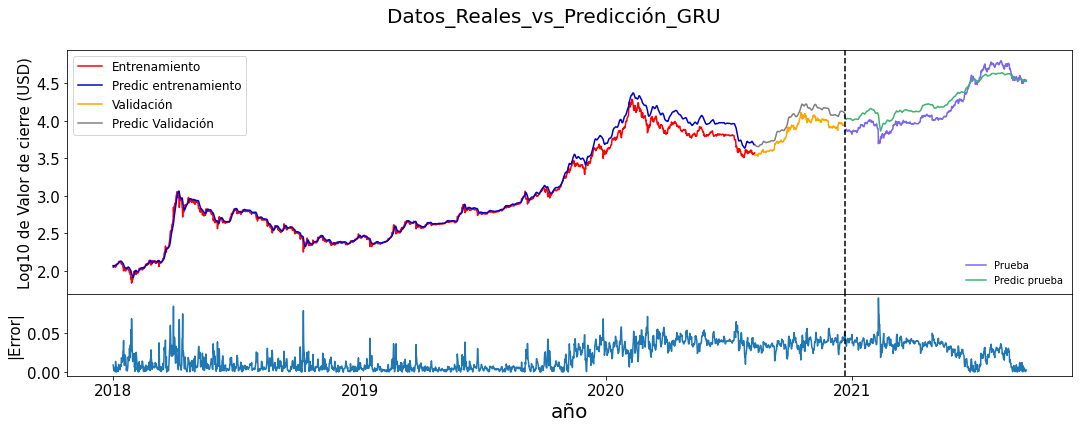

In [ ]:
graficar_prediccion(date_train[8:], 
                    trainY_inv,
                    date_validation[8:], 
                    ValY_inv,
                    date_test[8:], 
                    testY_inv,
                    trainPredict_GRU,
                    testPredict_GRU,
                    ValidationPredict_GRU,
                    mregru_gru,"Datos_Reales_vs_Predicción_GRU")

Luego de realizar la red neuronal, evidenciamos que el comportamiento que tiene es mucho más ajustado a la tendencia que obtuvimos por medio del modelo de AutoArima, lo que lo convierte en una solución más potente. Adicionalmente se evidencia que para los datos de entreanamiento se ve una curva muy señida con respecto a la de predicción lo que indica que hay Overtifiting del modelo en ese caso, pero que da un muy buen resultado cual se evalua el modelo con relación a los datos de test.

# **Guardar Modelo entrenado**

In [ ]:
joblib.dump(modelLSTM, 'modelo_bitcoinClose_LSTM.pkl') # Guardo el modelo.

INFO:tensorflow:Assets written to: ram://0036eab1-9f57-4f1a-b943-df23988373aa/assets


INFO:tensorflow:Assets written to: ram://0036eab1-9f57-4f1a-b943-df23988373aa/assets


['modelo_bitcoinClose_LSTM.pkl']